<a
href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab10.ipynb"
  target="_parent">
  <img
    src="https://colab.research.google.com/assets/colab-badge.svg"
    alt="Open In Colab"/>
</a>

# Transfer Learning/Fine-Tuning

In [3]:
from torchvision.models import resnet152
from torchvision import transforms, datasets, utils
from torch.utils.data import DataLoader, Dataset
import torch
from torch import optim, nn
import zipfile
from google.colab import files
import os
import sys
from PIL import Image, ImageOps
from tqdm.auto import tqdm
import numpy as np
from matplotlib import pyplot as plt

## Fine-tune a ResNet for image classification

In [ ]:
from google.colab import files
files.upload()
!pip install -q kaggle
!ls -lha kaggle.json
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
# download intel datasetfrom kaggle api with api key
!kaggle datasets download -d puneet6060/intel-image-classification

100% 345M/346M [00:15<00:00, 24.2MB/s]
100% 346M/346M [00:15<00:00, 23.6MB/s]


In [5]:
# Create dataset class for Intel dataset
class IntelDataset(Dataset):
    def __init__(self, zip_file='intel-image-classification.zip', size=150, train=True, upload=False):
        super(IntelDataset, self).__init__()
        self.train = train
        extract_dir = os.path.splitext(zip_file)[0]
        if not os.path.exists(extract_dir):
            os.makedirs(extract_dir)
            self.extract_zip(zip_file, extract_dir)
            self.resize(extract_dir, size=size)

        postfix = 'train' if train else 'test'

        if train:
            self.dataset_folder = datasets.ImageFolder(os.path.join(extract_dir, 'seg_train', 'seg_train'), transform=transforms.Compose([transforms.ToTensor()]))
        else:
            self.dataset_folder = datasets.ImageFolder(os.path.join(extract_dir, 'seg_test', 'seg_test'), transform=transforms.Compose([transforms.ToTensor()]))

    def resize(self, path, size=150):
        """Resizes all images in place"""
        print("Resizing images")
        dirs = os.walk(path)
        for root, dirs, files in os.walk(path):
            for item in files:
                name = os.path.join(root, item)
                if os.path.isfile(name):
                    im = Image.open(name)
                    im = ImageOps.fit(im, (size, size))
                    im.save(name[:-3] + 'bmp', 'BMP')
                    os.remove(name)

    def extract_zip(self, zip_file, extract_dir):
        print("Extracting", zip_file)
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)

    def __getitem__(self, i):
        return self.dataset_folder[i]

    def __len__(self):
        return len(self.dataset_folder)

intel_data = IntelDataset()

Extracting intel-image-classification.zip
Resizing images


In [6]:
intel_classes = intel_data.dataset_folder.classes
intel_classes

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [ ]:
model  = resnet152(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:02<00:00, 114MB/s]


In [ ]:
model.fc = nn.Linear(in_features=2048, out_features=len(intel_classes), bias=True)

In [7]:
# Edit the pretrained model to have the correct number of classes and freeze the layers
class CustomResNet(nn.Module):
    def __init__(self, num_classes, start_frozen=False):
        super(CustomResNet, self).__init__()

        self.num_classes = num_classes
        self.model = resnet152(pretrained=True)

        if start_frozen:
            # Turn off all gradients of the resnet
            for param in self.model.parameters():
                param.requires_grad = False

        self.model.fc = nn.Linear(in_features=2048, out_features=self.num_classes, bias=True)

    def unfreeze(self, n_layers):
        # Turn on gradients for the last n_layers
        params = list(self.model.parameters())[-n_layers:]
        for p in params:
            p.requires_grad = True

    def forward(self, x):
        # Pass x through the resnet
        return self.model(x)

In [8]:
def accuracy(y_hat, y_truth):

    preds = torch.argmax(y_hat, dim=1)
    acc = torch.mean((preds == y_truth).float()).item()
    return acc

def evaluate(model, objective, val_loader, device):

    val_losses = 0
    val_accs = 0
    batches = 0
    model.eval()

    with torch.no_grad():
        for x, y_truth in val_loader:

            batches += 1

            x, y_truth = x.to(device), y_truth.to(device)
            y_hat = model(x)
            val_loss = objective(y_hat, y_truth)
            val_acc = accuracy(y_hat, y_truth)

            val_losses += val_loss.item()
            val_accs += val_acc

    model.train()

    return val_losses/batches, val_accs/batches

In [16]:
def train(start_frozen=False, model_unfreeze=0, epochs=5):
    # Hyperparameters
    lr = .00005
    val_every = 50 
    num_classes = 6
    batch_size = 25
    device = torch.device('cuda:0')

    # Data
    # TODO: Use your own dataset
    train_dataset = IntelDataset(upload=True, train=True)
    val_dataset = IntelDataset(upload=True, train=False)
    train_loader = DataLoader(train_dataset,
                              shuffle=True,
                              num_workers=6,
                              batch_size=batch_size)
    val_loader = DataLoader(val_dataset,
                              shuffle=True,
                              num_workers=6,
                              batch_size=batch_size)

    # Model
    model = CustomResNet(num_classes, start_frozen=start_frozen).to(device)

    # Objective
    objective = nn.CrossEntropyLoss()
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-1)

    # Progress bar
    pbar = tqdm(total=len(train_loader) * epochs)

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    cnt = 0
    for epoch in range(epochs):

        # Implement model unfreezing
        if epoch < model_unfreeze:
            # Part 1.4
            # Unfreeze the last layers, one more each epoch
            model.unfreeze(epoch+1)

        for x, y_truth in train_loader:

            x, y_truth = x.to(device), y_truth.to(device)

            optimizer.zero_grad()

            y_hat = model(x)
            train_loss = objective(y_hat, y_truth)
            train_acc = accuracy(y_hat, y_truth)

            train_loss.backward()
            optimizer.step()

            train_accs.append(train_acc)
            train_losses.append(train_loss.item())

            if cnt % val_every == 0:
                val_loss, val_acc = evaluate(model, objective, val_loader, device)
                val_losses.append(val_loss)
                val_accs.append(val_acc)

            pbar.set_description('train loss:{:.4f}, train accuracy:{:.4f}.'.format(train_loss.item(), train_acc))
            pbar.update(1)
            cnt += 1

    pbar.close()
    plt.figure(figsize=(18,8))
    plt.subplot(121)
    plt.plot(np.arange(len(train_accs)), train_accs, label='Train Accuracy')
    plt.plot(np.arange(len(train_accs), step=val_every), val_accs, label='Val Accuracy')
    plt.legend()
    plt.subplot(122)
    plt.plot(np.arange(len(train_losses)), train_losses, label='Train Loss')
    plt.plot(np.arange(len(train_losses), step=val_every), val_losses, label='Val Loss')
    plt.legend()
    plt.show()

  0%|          | 0/1124 [00:00<?, ?it/s]

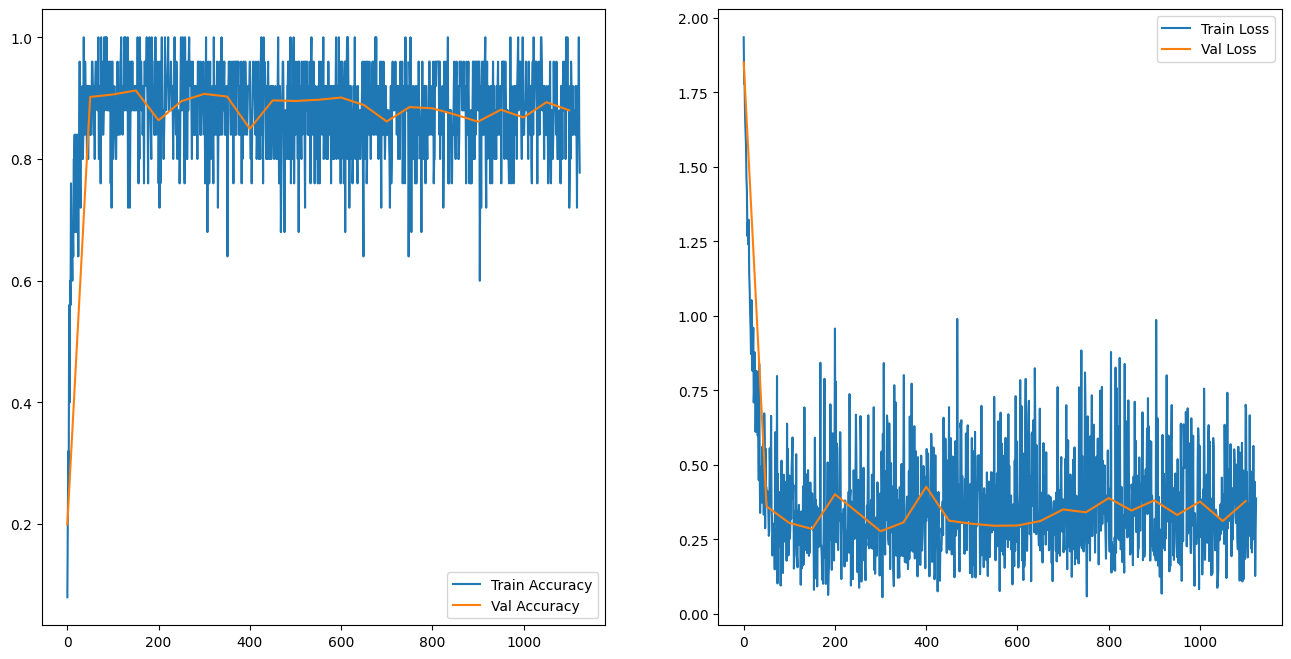

In [13]:
train(start_frozen=False, model_unfreeze=0)

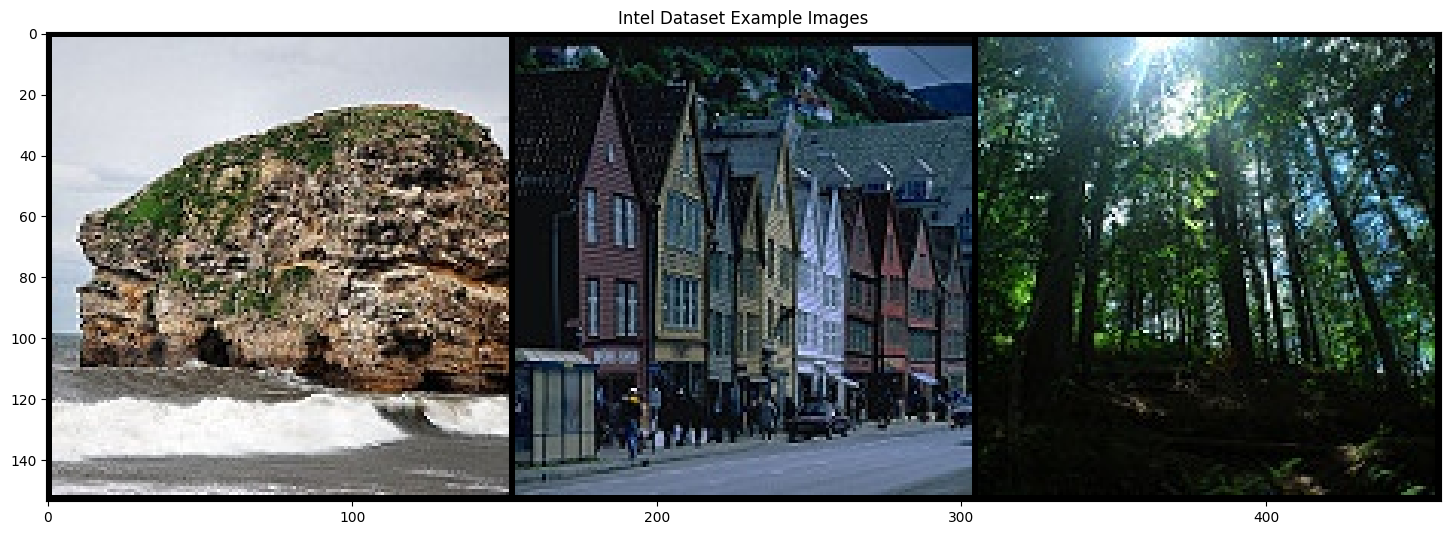

In [ ]:
# show three random images from the intel dataset
data_loader = DataLoader(intel_data, batch_size=3, shuffle=True)

def imshow(img):
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()
dataiter = iter(data_loader)
images, labels = next(dataiter)
plt.figure(figsize=(18, 14))
plt.title('Intel Dataset Example Images')
imshow(utils.make_grid(images))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/2810 [00:00<?, ?it/s]

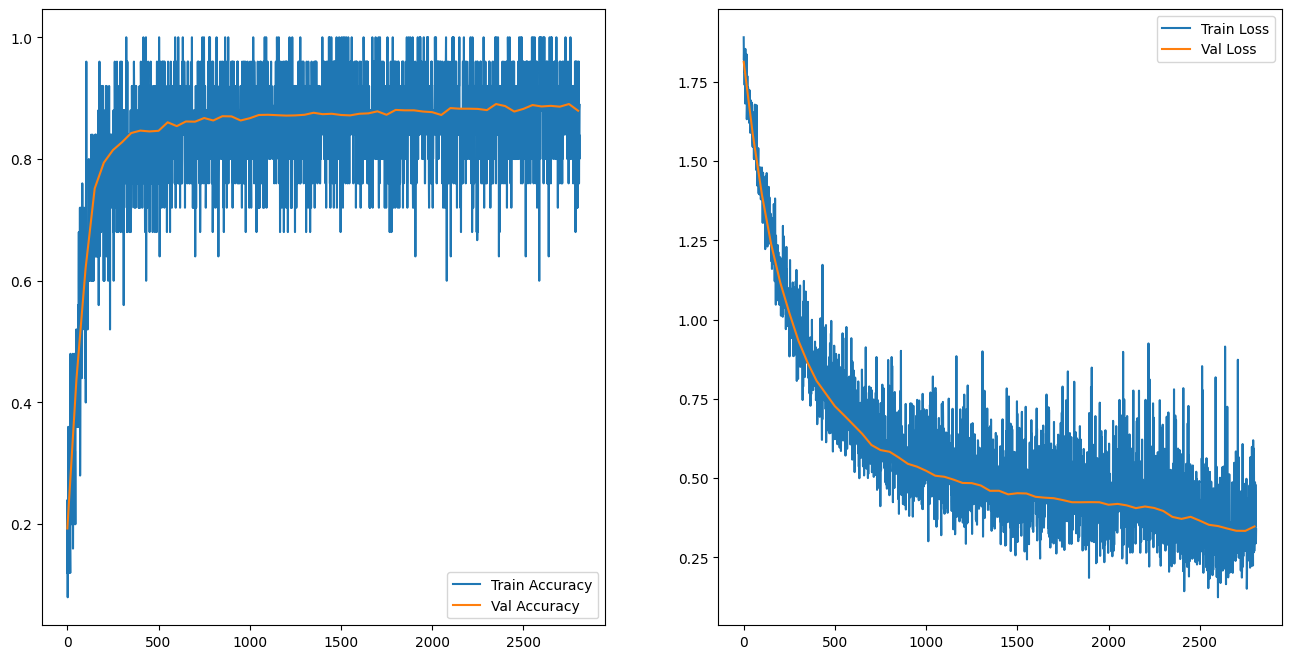

In [15]:
# Train again, but this time with unfreezing
train(start_frozen=True, model_unfreeze=5, epochs=5)